<a href="https://colab.research.google.com/github/tomasvainstein/7506R-2C2023-GRUPO05/blob/main/TP1/CHP3/7506R_TP1_GRUPO05_CHP3_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 1: Reservas de Hotel - CHP3
## Grupo 05 - Medialunas 🥐

### Integrantes:
| Integrante                              | Número de Padrón |
|----------------------------------------|------------------|
| Iara Elizabeth Jolodovsky      | 109385           |
| Tomas Vainstein Aranguren      | 109043           |
| Martin Abramovich              | 108762           |

## Librerias

In [1]:
%pip install 'dtreeviz'

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pickle
import numpy as np
import calendar
import sklearn as sk
import scipy.stats as st
from scipy import stats
from scipy import linalg
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, precision_recall_curve, roc_curve, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

##arboles
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('always')

## Funciones

In [3]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

**Cargamos el dataset de hotels train ya procesado en el CHP1 y el dataset hotels_test el cual debemos preprocesar igual que el train**

In [4]:
ds_hotels_train = pd.read_csv('./df_final_chp1.csv')
ds_training = ds_hotels_train.copy(deep=True)
ds_training['arrival_date'] = pd.to_datetime(ds_training['arrival_date'])

In [5]:
ds_hotels_test = pd.read_csv('./hotels_test.csv')
ds_testing_conId = ds_hotels_test.copy(deep=True)
ds_testing_conId.shape

(26535, 31)

Concatenamos arrival_date_year, arrival_date_month y arrival_date_day_of_month y unificamos en una variable arrival_date

In [6]:
ds_testing_conId['arrival_date'] = ds_testing_conId['arrival_date_year'].astype(str) + '-' + ds_testing_conId['arrival_date_month'] + '-' + ds_testing_conId['arrival_date_day_of_month'].astype(str)
ds_testing_conId.drop(columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], inplace=True)
ds_testing_conId['arrival_date'] = pd.to_datetime(ds_testing_conId['arrival_date'])

Y pasamos child de float a int

In [7]:
ds_testing_conId['children'] = ds_testing_conId['children'].astype(int)

Juntamos children y babies

In [8]:
ds_testing_conId['minors'] = ds_testing_conId['children'] + ds_testing_conId['babies']

ds_testing_conId = ds_testing_conId.drop(columns=['children', 'babies'])

In [9]:
ds_testing_conId.head()

,hotel,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,market_segment,distribution_channel,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,arrival_date,minors
0,City Hotel,277,46,1,2,2,BB,PRT,Groups,TA/TO,...,NaN,0,Transient,100.0,0,0,2016-04-04,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,2016-11-07,0
1,City Hotel,286,20,0,4,2,BB,PRT,Groups,TA/TO,...,NaN,176,Transient-Party,101.0,0,0,2016-01-22,aba9aac2-4495-4645-a60e-90328713c999,2016-05-11,0
2,City Hotel,0,35,0,1,3,BB,FRA,Online TA,TA/TO,...,NaN,0,Transient,225.0,0,2,2016-08-24,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,2016-08-23,0
3,Resort Hotel,196,44,2,5,2,BB,DEU,Online TA,TA/TO,...,NaN,0,Transient,96.0,0,0,2016-11-05,ce1b400e-afa1-4946-bdff-004b859eb61c,2016-10-29,2
4,Resort Hotel,232,48,2,1,2,BB,PRT,Groups,TA/TO,...,NaN,0,Transient,30.0,0,0,2016-10-18,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,2016-11-26,0


In [10]:
ds_testing_conId.shape

(26535, 28)

In [11]:
ds_training.dtypes

Unnamed: 0                                 int64
hotel                                     object
lead_time                                  int64
arrival_date_week_number                   int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type                        object
booking_changes                            int64
deposit_type                              object
agent                                    float64
company                                  float64
days_in_waiting_list

Eliminamos reservation status date de testing ya que no existe en training

In [12]:
ds_testing_conId= ds_testing_conId.drop(columns=['reservation_status_date'])

### One Hot Encoding para variables categóricas

Los NaN de agent y company tenemos que manejarlos. En este caso decidimos convertirlos a -1

In [13]:
ds_training['agent'].fillna(-1, inplace=True)
ds_training['company'].fillna(-1, inplace=True)
ds_testing_conId['agent'].fillna(-1, inplace=True)
ds_testing_conId['company'].fillna(-1, inplace=True)

In [14]:
ds_training = pd.get_dummies(ds_training, columns=["hotel","meal","country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"], drop_first=True)
ds_training.head()

,Unnamed: 0,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,49,37,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,4,44,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,25,42,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,26,51,2,5,2,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,4,104,12,2,5,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
ds_testing_conId = pd.get_dummies(ds_testing_conId, columns=["hotel","meal","country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"], drop_first=True)
ds_testing_conId.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,277,46,1,2,2,0,0,0,0,-1.0,...,0,0,0,0,0,1,0,0,1,0
1,286,20,0,4,2,0,0,0,0,30.0,...,0,0,0,0,0,0,0,0,0,1
2,0,35,0,1,3,0,0,0,0,-1.0,...,0,0,0,0,0,0,0,0,1,0
3,196,44,2,5,2,0,0,0,0,240.0,...,1,0,0,0,0,0,0,0,1,0
4,232,48,2,1,2,0,0,0,0,11.0,...,0,0,0,0,0,1,0,0,1,0


Necesitamos que la fecha sea un int

In [16]:
ds_training['arrival_date_unix'] = (ds_training['arrival_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)
ds_training = ds_training.drop(columns=['arrival_date'], inplace=False)

ds_testing_conId['arrival_date_unix'] = (ds_testing_conId['arrival_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)
ds_testing_conId = ds_testing_conId.drop(columns=['arrival_date'], inplace=False)

In [17]:
ds_testing_sinId = ds_testing_conId.drop(columns=['id'], inplace=False)

In [18]:
nans_por_columna = ds_training.isna().sum()

# Filtrar las columnas con valores NaN
columnas_con_nans = nans_por_columna[nans_por_columna > 0]

# Imprimir las columnas con NaN y la cantidad de NaN en cada una
if not columnas_con_nans.empty:
    print("Columnas con valores NaN y la cantidad de NaN en cada una:")
    print(columnas_con_nans)
else:
    print("No hay columnas con valores NaN en ds_training.")

No hay columnas con valores NaN en ds_training.


Dividimos el ds train para testear nuestros modelos

In [19]:
# Dividir los datos en entrenamiento y prueba
ds_entrenamiento, ds_testeo = train_test_split(
    ds_training,  # DataFrame original
    test_size=0.2,  # Proporción de datos de prueba
    random_state=10  # Semilla aleatoria para reproducibilidad
)

# Definir X e Y para ambos conjuntos
X_entrenamiento = ds_entrenamiento.drop(['is_canceled'], axis=1)
X_testeo = ds_testeo.drop(['is_canceled'], axis=1)
Y_entrenamiento = ds_entrenamiento['is_canceled']
Y_testeo = ds_testeo['is_canceled']

# Eliminar la columna 'id' en ambos conjuntos
X_entrenamiento = X_entrenamiento.drop(columns=['id'])
X_testeo = X_testeo.drop(columns=['id'])

## KNN Busqueda de Hiperparametros (NO VOLVER A EJECUTAR)

In [ ]:
params_grid={ 'n_neighbors':range(1,30),
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)

rand.fit(X_entrenamiento, Y_entrenamiento)
rand.cv_results_['mean_test_score']

array([0.59422517, 0.5613363 , 0.58694405, 0.58542565, 0.59212417,
       0.56487277, 0.59813596, 0.58765158, 0.60602011, 0.58650728])

In [ ]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 19, 'metric': 'manhattan', 'algorithm': 'brute'}
0.6060201134853601


In [ ]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(X_testeo)

#Accuracy test
accuracy_score(Y_testeo,y_pred)

0.6060908637044433

              precision    recall  f1-score   support

           0       0.61      0.59      0.60      5976
           1       0.61      0.62      0.61      6042

    accuracy                           0.61     12018
   macro avg       0.61      0.61      0.61     12018
weighted avg       0.61      0.61      0.61     12018



Text(50.722222222222214, 0.5, 'True')

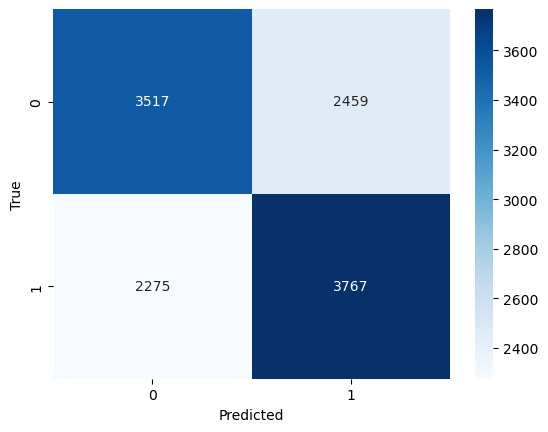

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(Y_testeo,y_pred))

#Matriz de Confusión
cm = confusion_matrix(Y_testeo,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Kaggle

In [ ]:
ds_entrenamiento_kaggle = ds_training.copy(deep=True)
X_entrenar_kaggle = ds_entrenamiento_kaggle.drop(columns=['id', "is_canceled"], axis=1)
Y_entrenar_kaggle = ds_entrenamiento_kaggle["is_canceled"]

In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=best_knn.get_params()['n_neighbors'],
                               weights=best_knn.get_params()['weights'],
                               algorithm=best_knn.get_params()['algorithm'],
                               metric=best_knn.get_params()['metric'])

# Entrena el modelo con los datos de entrenamiento de Kaggle
best_knn.fit(X_entrenar_kaggle, Y_entrenar_kaggle)

KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=19,
                     weights='distance')

In [ ]:
nombre_archivo = "./modelos/knn.pickle"
pickle.dump(best_knn, open(nombre_archivo, "wb"))

/tmp/ipykernel_29239/3994601148.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='./modelos/knn.pickle'>


In [ ]:
ds_testing_sinId = ds_testing_sinId.reindex(columns= X_entrenamiento.columns, fill_value = 0)

In [ ]:
predicciones_kaggle = best_knn.predict(ds_testing_sinId)

In [ ]:
ds_submit = pd.DataFrame({'id':ds_testing_conId['id'], 'is_canceled':predicciones_kaggle})
ds_submit.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [ ]:
from pathlib import Path
filepath = Path('submission/submit_knnV1.csv')
ds_submit.to_csv(filepath, index=False)

## SVM sin PCA

In [ ]:
#Imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import time

In [ ]:
#Armo una version escalada con minmax (media=0 , var=1  )
min_max_scaler = preprocessing.MinMaxScaler()
X_entrenamiento_minmax = min_max_scaler.fit_transform(X_entrenamiento)
X_testeo_minmax  = min_max_scaler.transform(X_testeo)

#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
X_entrenamiento_norm = stand_scaler.fit_transform(X_entrenamiento)
X_testeo_norm=stand_scaler.transform(X_testeo)

In [ ]:
#Construyo un modelo SVM
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(X_entrenamiento, Y_entrenamiento)

#Hago la prediccion y calculo las métricas
y_pred=svm.predict(X_testeo)
metricas(y_pred,Y_testeo)

In [ ]:
#Construyo un modelo SVM
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(X_entrenamiento_norm, Y_entrenamiento)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(X_testeo_norm)
metricas(y_pred_norm,Y_testeo)

In [ ]:
#Construyo un modelo SVM
svm_minmax= SVC()

#Lo entreno con los datos escalados con min max
svm_minmax.fit(X_entrenamiento_minmax, Y_entrenamiento)

#Hago la prediccion y calculo las métricas
y_pred_minmax=svm_minmax.predict(X_testeo_minmax)
metricas(y_pred_minmax,Y_testeo)

## SVM con PCA

In [ ]:
sc = StandardScaler()
x_train_scaled = sc.fit_transform(X_entrenamiento)

pca = PCA(n_components = None)
pca.fit(x_train_scaled)


NameError: name 'PCA' is not defined

In [ ]:
componentes = len(pca.explained_variance_ratio_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Text(0, 0.5, 'Varianza Explicada (%)')

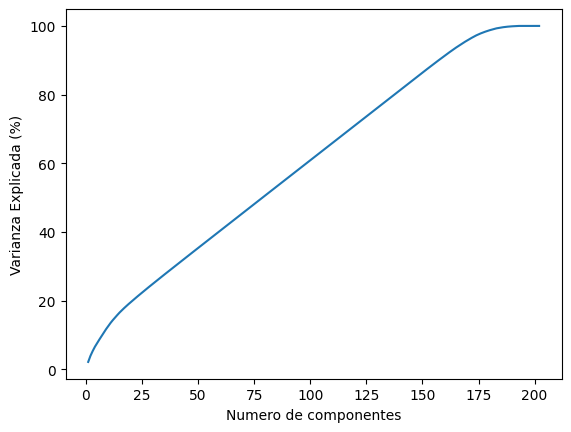

In [ ]:
#Graficamos la Varianza
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")

In [ ]:
acumulated_variance_ratio = np.cumsum(pca.explained_variance_ratio_ * 100)
indices_superadores = {}
for porcentaje in [5,10,15,20,25,30,35,50,90]:
    indices_superadores[porcentaje] = np.searchsorted(acumulated_variance_ratio, porcentaje) + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
print("Podemos ver en el grafico que:")
for porcentaje in indices_superadores:
    indice_superador = indices_superadores[porcentaje]
    print("Se alcanza a cubrir el", porcentaje,"% de la varianza con las primeras",indice_superador, "variabes")

Podemos ver en el grafico que:
Se alcanza a cubrir el 5 % de la varianza con las primeras 3 variabes
Se alcanza a cubrir el 10 % de la varianza con las primeras 8 variabes
Se alcanza a cubrir el 15 % de la varianza con las primeras 13 variabes
Se alcanza a cubrir el 20 % de la varianza con las primeras 21 variabes
Se alcanza a cubrir el 25 % de la varianza con las primeras 30 variabes
Se alcanza a cubrir el 30 % de la varianza con las primeras 40 variabes
Se alcanza a cubrir el 35 % de la varianza con las primeras 50 variabes
Se alcanza a cubrir el 50 % de la varianza con las primeras 79 variabes
Se alcanza a cubrir el 90 % de la varianza con las primeras 158 variabes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


              precision    recall  f1-score   support

           0       0.76      0.79      0.77      5976
           1       0.78      0.76      0.77      6042

    accuracy                           0.77     12018
   macro avg       0.77      0.77      0.77     12018
weighted avg       0.77      0.77      0.77     12018



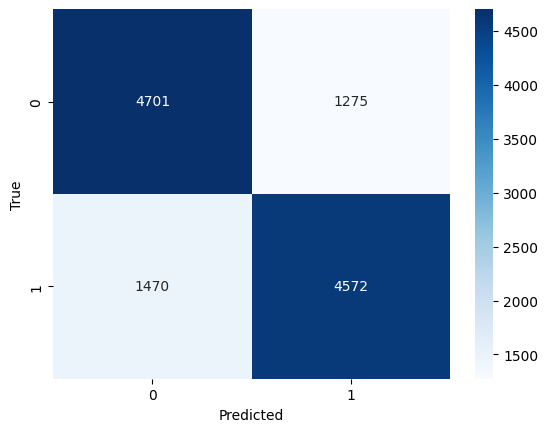

In [ ]:
from sklearn.pipeline import Pipeline

#Defino el tipo de escalado, la transformacion PCA y el modelo
_sc = StandardScaler()
_pca = PCA(n_components = 6)
_model = SVC()

#Creo un pipeline
svm_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('svm', _model)
])

#Entreno sobre los datos que serán previamente escalados y transformados
svm_model.fit(X_entrenamiento,Y_entrenamiento)

#Hago la predicción y calculo las métricas
y_pred_pca=svm_model.predict(X_testeo)
metricas(y_pred_pca,Y_testeo)

Kaggle:

In [ ]:
y_pred_svc_kaggle = svm_model.predict(ds_testing_sinId)

In [ ]:
ds_submit = pd.DataFrame({'id':ds_testing_conId['id'], 'is_canceled':y_pred_svc_kaggle})
ds_submit.head()

In [ ]:
from pathlib import Path
filepath = Path('submission/submit_svc_pcaV1.csv')
ds_submit.to_csv(filepath, index=False)

### Probamos con distintos Kernels

Lineal:

In [ ]:
#Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='linear', C=5)
clf.fit(X_entrenamiento_minmax, Y_entrenamiento)

#Hago la predicción y calculo las métricas
y_pred_lin=clf.predict(X_testeo_minmax)
metricas(y_pred_lin,Y_testeo)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Polinomico:

In [ ]:
#Creo un clasificador con kernel polinomico y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='poly', C=5, degree=10, gamma=10, coef0=10)
clf.fit(X_entrenamento_minmax, Y_entrenamiento)

#Hago la predicción y calculo las métricas
y_pred_pol=clf.predict(X_testeo_minmax)
metricas(y_pred_pol,Y_testeo)

Radial:

In [ ]:
#Creo un clasificador con kernel radial y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='rbf', C=5, gamma=10)
clf.fit(X_entrenamiento_minmax, Y_entrenamiento)

#Hago la predicción y calculo las métricas
y_pred_rad=clf.predict(X_testeo_minmax)
metricas(y_pred_rad,Y_testeo)

## Random Forest

In [29]:
scorer = make_scorer(f1_score)

In [46]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)

param = {
    "n_estimators": [100, 200, 300],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}

rs = RandomizedSearchCV(estimator=rf, param_distributions=param, scoring=scorer, cv=5, n_iter=10, random_state=1)

In [47]:
rs.fit(X_entrenamiento, Y_entrenamiento)

/usr/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
/usr/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
/usr/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTree

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=1, scoring=make_scorer(f1_score))

In [32]:
print(rs.best_estimator_)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=300, n_jobs=-1, random_state=1)


In [33]:
print("Mejor Score: ", rs.best_score_)

Mejor Score:  0.8793790779190255


In [34]:
rf_best = rs.best_estimator_

y_pred =rf_best.predict(X_testeo)

In [35]:
accuracy = accuracy_score(Y_testeo, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.74%


In [36]:
f1 = f1_score(Y_testeo, y_pred)
print("F1: %.2f%%" % (f1 * 100.0))

F1: 87.83%


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5976
           1       0.88      0.88      0.88      6042

    accuracy                           0.88     12018
   macro avg       0.88      0.88      0.88     12018
weighted avg       0.88      0.88      0.88     12018



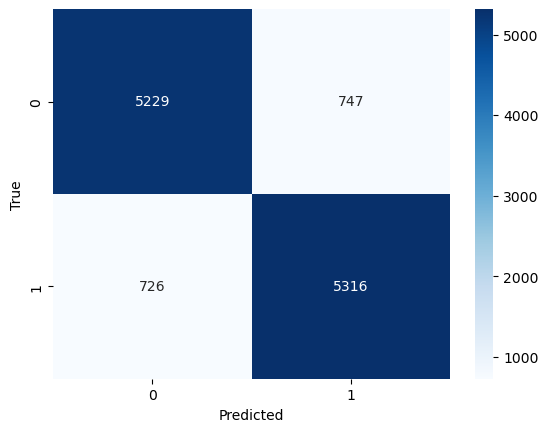

In [37]:
metricas(y_pred,Y_testeo)

In [39]:
##Exportamos pickle
nombre_archivo = "./modelos/rf_full_best2.pickle"
pickle.dump(rf_best, open(nombre_archivo, "wb"))

/tmp/ipykernel_45013/3382621166.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='./modelos/rf_full_best2.pickle'>


### Kaggle

In [40]:
ds_testing_sinId = ds_testing_sinId.reindex(columns=X_entrenamiento.columns, fill_value=0)

In [41]:
y_pred_kaggle_rf = rf_best.predict(ds_testing_sinId)

In [42]:
ds_submit = pd.DataFrame({'id':ds_testing_conId['id'], 'is_canceled':y_pred_kaggle_rf})
ds_submit.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [43]:
from pathlib import Path
filepath = Path('submission/submit_rfV2.csv')
ds_submit.to_csv(filepath, index=False)

## XGBoost

In [21]:
#Creo el modelo y lo entreno

import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(X_entrenamiento, Y_entrenamiento)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

AUC: 0.9489499845348514
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      5976
           1       0.86      0.88      0.87      6042

    accuracy                           0.87     12018
   macro avg       0.87      0.87      0.87     12018
weighted avg       0.87      0.87      0.87     12018



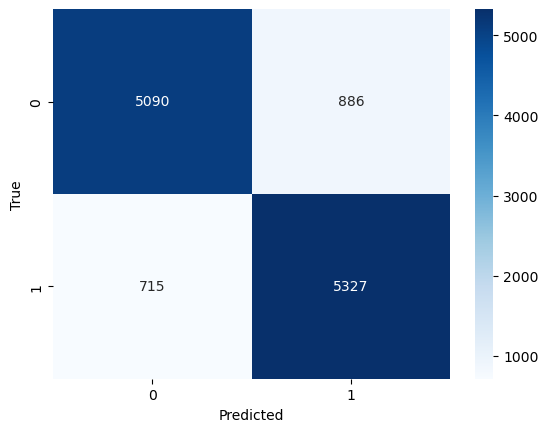

In [22]:
#Evaluo en el set de test
y_pred_proba= xgb_model.predict_proba(X_testeo)[:, 1]
print('AUC:',roc_auc_score(Y_testeo, y_pred_proba))

#Matriz de Confusion
y_pred=xgb_model.predict(X_testeo)

cm = confusion_matrix(Y_testeo,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(Y_testeo,y_pred))

In [23]:
#Datos de entrenamiento en formaro DMatrix
data_dmatrix = xgb.DMatrix(data=X_entrenamiento, label=Y_entrenamiento)

#Entreno CV para probar el learning rate
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.1},num_boost_round=8,metrics='auc')
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.895245,0.000574,0.893588,0.001462
1,0.899305,0.001515,0.898014,0.001765
2,0.901217,0.000887,0.899547,0.000825
3,0.904345,0.001639,0.902607,0.002061
4,0.907011,0.002502,0.905126,0.003042
5,0.909467,0.001327,0.907788,0.001808
6,0.911507,0.001705,0.909744,0.001463
7,0.913817,0.000829,0.912088,0.001504


In [24]:
#Entreno CV para probar el learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.2},num_boost_round=8,metrics='auc',seed=0)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.895245,0.000574,0.893588,0.001462
1,0.901247,0.001036,0.899953,0.001376
2,0.908063,0.001569,0.906553,0.001454
3,0.911540,0.001665,0.909752,0.002487
4,0.914103,0.001293,0.912407,0.001599
5,0.918285,0.001991,0.916305,0.001979
6,0.920275,0.001101,0.917917,0.001494
7,0.922968,0.001008,0.920454,0.001943


### Kaggle

In [25]:
ds_testing_sinId = ds_testing_sinId.reindex(columns=X_entrenamiento.columns, fill_value=0)

In [26]:
y_pred_xgb_kaggle = xgb_model.predict(ds_testing_sinId)

In [27]:
ds_submit = pd.DataFrame({'id':ds_testing_conId['id'], 'is_canceled':y_pred_xgb_kaggle})
ds_submit.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [28]:
from pathlib import Path
filepath = Path('submission/submit_xgbV1.csv')
ds_submit.to_csv(filepath, index=False)